# Part Pre: Data Cleansing & Constructing

In [2]:
import importlib
import re
import time
import os
import inspect
import random
import json
import joblib
import rdkit
import pickle  as pk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL.Image
import mordred

from mordred import Calculator, descriptors

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import DataStructs
from rdkit.Chem import rdFingerprintGenerator


from utilities import smiles_dataset, save_dataset, get_parameters, get_descriptors, drop_nonnumeric_columns, select_features
from utilities import fit_result, get_parameters
from utilities import hp_opt
from utilities import plot_multi_learning_curves


#from PIL import Image
from sklearn.manifold import TSNE

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.linear_model import Lasso, Ridge, LinearRegression, ElasticNet

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import set_config
set_config(print_changed_only=False) #Print all estimator parameters
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, GridSearchCV

from importlib       import reload 
from IPython.display import Image




In [4]:
database_list = ['inhouse', 'inhousechembl', 'bms300k', 'chembl34', 'clickcyctetpep', 'coconut', 
                 'cyctetpep', 'divset', 'enaminescreening', 
                 'enaminePPI', 'iPPI', 'npatlas', 'reinventPPI', 'chemdivkras']
for database in database_list:
    file_name = '.\\datasets\\input\\'+ database +'.csv'
    df_smiles = pd.read_csv(file_name, delimiter=',')
    df_fp = smiles_dataset(df_smiles, 'smiles')
    save_dataset(df_fp, file_name = 'x_' + database + '_fp', idx = False)

Current path is: D:\Mitarbeiter\Nava_Hoeer\machine-learning_nozeroldc\datasets
Path already existed.
Dataset saved successfully.
Current path is: D:\Mitarbeiter\Nava_Hoeer\machine-learning_nozeroldc\datasets
Path already existed.
Dataset saved successfully.
Current path is: D:\Mitarbeiter\Nava_Hoeer\machine-learning_nozeroldc\datasets
Path already existed.
Dataset saved successfully.
Current path is: D:\Mitarbeiter\Nava_Hoeer\machine-learning_nozeroldc\datasets
Path already existed.
Dataset saved successfully.
Current path is: D:\Mitarbeiter\Nava_Hoeer\machine-learning_nozeroldc\datasets
Path already existed.
Dataset saved successfully.


[08:41:42] Can't kekulize mol.  Unkekulized atoms: 4 5 12 13 20


Current path is: D:\Mitarbeiter\Nava_Hoeer\machine-learning_nozeroldc\datasets
Path already existed.
Dataset saved successfully.
Current path is: D:\Mitarbeiter\Nava_Hoeer\machine-learning_nozeroldc\datasets
Path already existed.
Dataset saved successfully.
Current path is: D:\Mitarbeiter\Nava_Hoeer\machine-learning_nozeroldc\datasets
Path already existed.
Dataset saved successfully.
Current path is: D:\Mitarbeiter\Nava_Hoeer\machine-learning_nozeroldc\datasets
Path already existed.
Dataset saved successfully.
Current path is: D:\Mitarbeiter\Nava_Hoeer\machine-learning_nozeroldc\datasets
Path already existed.
Dataset saved successfully.
Current path is: D:\Mitarbeiter\Nava_Hoeer\machine-learning_nozeroldc\datasets
Path already existed.
Dataset saved successfully.
Current path is: D:\Mitarbeiter\Nava_Hoeer\machine-learning_nozeroldc\datasets
Path already existed.
Dataset saved successfully.
Current path is: D:\Mitarbeiter\Nava_Hoeer\machine-learning_nozeroldc\datasets
Path already exist

##### When calculating the descriptors in the mordred environment some molecules are dropped. RDKit raised errors when trying to convert smiles to mol. The chembl34 and the coconut libraries were affected. The affected molecules were dropped from the respective libraries and the latter saved as *_dropped.csv. The fingerprints are here recalculated from the reduced libraries.

In [2]:
database_list = ['chembl34_dropped', 'coconut_dropped']
for database in database_list:
    file_name = '.\\datasets\\input\\'+ database +'.csv'
    df_smiles = pd.read_csv(file_name, delimiter=',')
    df_fp = smiles_dataset(df_smiles, 'smiles')
    save_dataset(df_fp, file_name = 'x_' + database + '_fp', idx = False)

Current path is: D:\Mitarbeiter\Nava_Hoeer\machine-learning_nozeroldc\datasets
Path already existed.
Dataset saved successfully.


[18:32:59] Can't kekulize mol.  Unkekulized atoms: 4 5 12 13 20


Current path is: D:\Mitarbeiter\Nava_Hoeer\machine-learning_nozeroldc\datasets
Path already existed.
Dataset saved successfully.


In [ ]:
# shape of the fingerprint databases excluding dropped molecules
database_list = ['inhouse', 'inhousechembl', 'bms300k', 'chembl34_dropped', 'clickcyctetpep', 'coconut_dropped', 
                 'cyctetpep', 'divset', 'enaminescreening', 
                 'enaminePPI', 'iPPI', 'npatlas', 'reinventPPI', 'chemdivkras']
for database in database_list:
    file_name = '.\\datasets\\x_'+ fp +'_fp.csv'
    print(f"{fp}: {pd.read_csv(file_name, delimiter=',').shape}")

In [ ]:
# shape of the descriptor databases excluding dropped molecules
database_list = ['inhouse', 'inhousechembl', 'bms300k', 'chembl34_dropped', 'clickcyctetpep', 'coconut_dropped', 
                 'cyctetpep', 'divset', 'enaminescreening', 
                 'enaminePPI', 'iPPI', 'npatlas', 'reinventPPI', 'chemdivkras']
for database in database_list:
    file_name = '.\\datasets\\x_'+ database +'_desc20.csv'
    print(f"{database}: {pd.read_csv(file_name, delimiter=',').shape}")

In [ ]:
# shape of the smiles databases excluding dropped molecules
database_list = ['inhouse', 'inhousechembl', 'bms300k', 'chembl34_dropped', 'clickcyctetpep', 'coconut_dropped', 
                 'cyctetpep', 'divset', 'enaminescreening', 
                 'enaminePPI', 'iPPI', 'npatlas', 'reinventPPI', 'chemdivkras']
for database in database_list:
    file_name = '.\\datasets\\input\\'+ database +'.csv'
    print(f"{database}: {pd.read_csv(file_name, delimiter=',').shape}")

# Part A: Clustering

In [24]:
# Import In-house and In-house+ChEMBL-extension libraries

df_inhouse = pd.read_csv(r'.\datasets\input\inhouse.csv', delimiter=',')
df_inhousechembl = pd.read_csv(r'.\datasets\input\inhousechembl.csv', delimiter=',')
print(df_inhouse.shape)
print(df_inhousechembl.shape)

(603, 4)
(917, 4)


In [25]:
# save the target values of In-house and In-house+ChEMBL-extension libraries
save_dataset(df_inhouse['pChEMBL'], file_name = 'y_inhouse', idx = False)
save_dataset(df_inhousechembl['pChEMBL'], file_name = 'y_inhousechembl', idx = False)

Current path is: D:\Mitarbeiter\Nava_Hoeer\machine-learning_nozeroldc\datasets
Path already existed.
Dataset saved successfully.
Current path is: D:\Mitarbeiter\Nava_Hoeer\machine-learning_nozeroldc\datasets
Path already existed.
Dataset saved successfully.


Current path is: D:\Mitarbeiter\Nava_Hoeer\machine-learning_nozeroldc\figures
Path already existed.


C:\Users\User\AppData\Local\Temp\ipykernel_11808\2321100861.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('plasma')


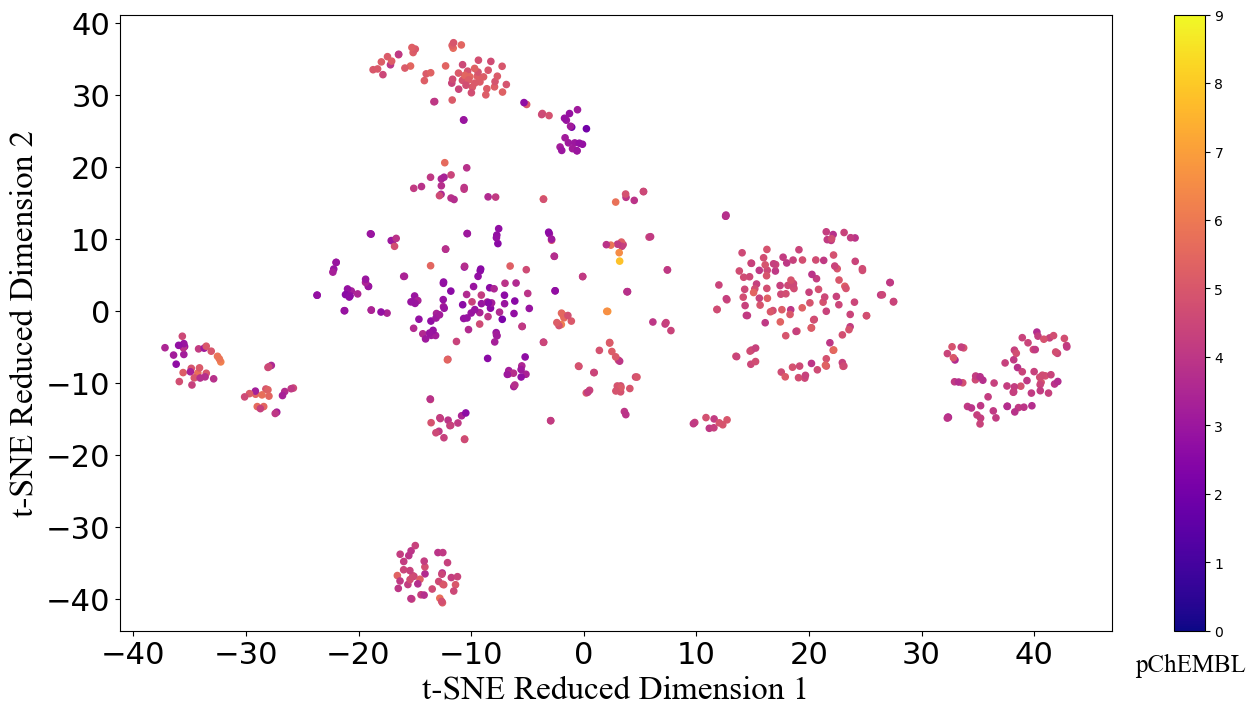

In [33]:
"""Create TSNE plot of In-house library"""

np.random.seed(42)

path = os.path.join(os.getcwd(), 'figures')
print('Current path is:', path)

if os.path.exists(path) == True:
    pass
    print('Path already existed.')
else:
    os.mkdir(path)
    print('Path created.')

x_values = pd.read_csv('./datasets/x_inhouse_fp.csv').values
y_values = pd.read_csv('./datasets/y_inhouse.csv').values.ravel()
tsne_descriptors = TSNE(n_components=2, random_state = 42)
x_tsne = tsne_descriptors.fit_transform(x_values)


# draw tsne
cm = plt.cm.get_cmap('plasma')
plt.figure(figsize=(16, 8))
plt.xticks(size = 22)
plt.yticks(size = 22)
plt.xlabel('t-SNE Reduced Dimension 1',fontproperties = 'Times New Roman', size = 24)
plt.ylabel('t-SNE Reduced Dimension 2',fontproperties = 'Times New Roman', size = 24)
plt.scatter(x_tsne[:, 0], x_tsne[:,1],c= y_values,vmin= 0, vmax= 9, s= 20, cmap=cm)
plt.colorbar()
plt.text(49, -50, "pChEMBL", fontproperties = 'Times New Roman', size = 18)
plt.savefig("figures/TSNE_inhouse.png", bbox_inches='tight', pad_inches= 0)

tsne_image = PIL.Image.open('figures/TSNE_inhouse.png')
tsne_image.show()

Current path is: D:\Mitarbeiter\Nava_Hoeer\machine-learning_nozeroldc\figures
Path already existed.


C:\Users\User\AppData\Local\Temp\ipykernel_11808\3125191191.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('plasma')


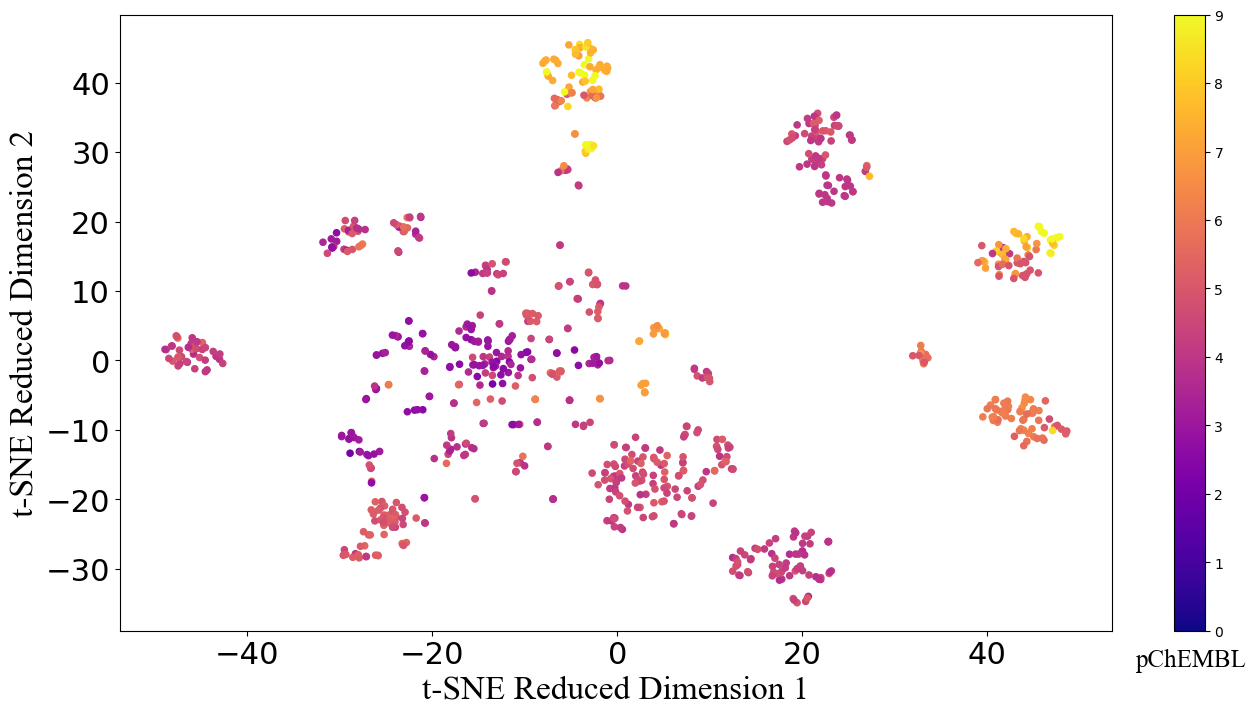

In [39]:
"""Create TSNE plot of In-house+ChEMBL library"""

np.random.seed(42)

path = os.path.join(os.getcwd(), 'figures')
print('Current path is:', path)

if os.path.exists(path) == True:
    pass
    print('Path already existed.')
else:
    os.mkdir(path)
    print('Path created.')

x_values = pd.read_csv('./datasets/x_inhousechembl_fp.csv').values
y_values = pd.read_csv('./datasets/y_inhousechembl.csv').values.ravel()
tsne_descriptors = TSNE(n_components=2, random_state = 42)
x_tsne = tsne_descriptors.fit_transform(x_values)


# draw tsne
cm = plt.cm.get_cmap('plasma')
plt.figure(figsize=(16, 8))
plt.xticks(size = 22)
plt.yticks(size = 22)
plt.xlabel('t-SNE Reduced Dimension 1',fontproperties = 'Times New Roman', size = 24)
plt.ylabel('t-SNE Reduced Dimension 2',fontproperties = 'Times New Roman', size = 24)
plt.scatter(x_tsne[:, 0], x_tsne[:,1],c= y_values,vmin= 0, vmax= 9, s= 20, cmap=cm)
plt.colorbar()
plt.text(56, -44, "pChEMBL", fontproperties = 'Times New Roman', size = 18)
plt.savefig("figures/TSNE_inhousechembl.png", bbox_inches='tight', pad_inches= 0)

tsne_image = PIL.Image.open('figures/TSNE_inhousechembl.png')
tsne_image.show()

Current path is: D:\Mitarbeiter\Nava_Hoeer\machine-learning\figures
Path already existed.


C:\Users\User\AppData\Local\Temp\ipykernel_6612\3891087064.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('plasma')


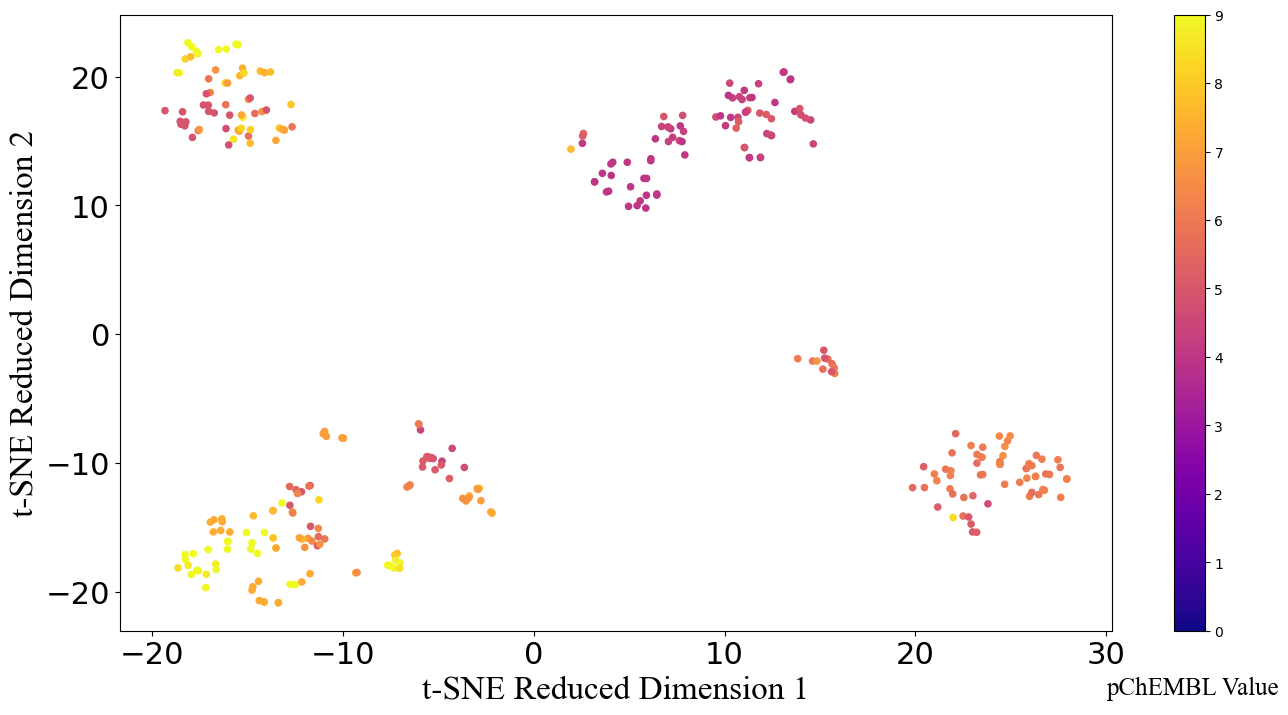

In [57]:
"""Create TSNE plot of ChEMBL-extension"""

np.random.seed(42)

path = os.path.join(os.getcwd(), 'figures')
print('Current path is:', path)

if os.path.exists(path) == True:
    pass
    print('Path already existed.')
else:
    os.mkdir(path)
    print('Path created.')

x_values = pd.read_csv('./datasets/x_chembl.csv').values
y_values = pd.read_csv('./datasets/y_chembl.csv').values.ravel()
tsne_descriptors = TSNE(n_components=2, random_state = 42)
x_tsne = tsne_descriptors.fit_transform(x_values)


# draw tsne
cm = plt.cm.get_cmap('plasma')
plt.figure(figsize=(16, 8))
plt.xticks(size = 22)
plt.yticks(size = 22)
plt.xlabel('t-SNE Reduced Dimension 1',fontproperties = 'Times New Roman', size = 24)
plt.ylabel('t-SNE Reduced Dimension 2',fontproperties = 'Times New Roman', size = 24)
plt.scatter(x_tsne[:, 0], x_tsne[:,1],c= y_values,vmin= 0, vmax= 9, s= 20, cmap=cm)
plt.colorbar()
plt.text(30, -28, "pChEMBL Value", fontproperties = 'Times New Roman', size = 18)
plt.savefig("figures/TSNE_chembl.png", bbox_inches='tight', pad_inches= 0)

tsne_image = PIL.Image.open('figures/TSNE_chembl.png')
tsne_image.show()

# Part B: Hyperparameter Optimisation & Performance Assessment with Nested Cross-Validation

In [80]:
np.random.seed(42)

#initialise score lists
knn_results = []
ridge_results = []
lasso_results = []
elastic_results = []
gb_results = []
rf_results = []
ada_results = []
extra_results = []
dt_results = []
svr_results = []

# retrieve datasets
dataset_fp = pd.read_csv('./datasets/x_inhousechembl_fp.csv')
dataset_desc = pd.read_csv('./datasets/x_inhousechembl_desc20.csv')
target = pd.read_csv('./datasets/y_inhousechembl.csv')

# outer CV split
foldcounter=1
totalfolds=5
kf = KFold(n_splits=totalfolds, shuffle=True, random_state=42)
for train_ix, test_ix in kf.split(dataset_fp):
    train_fp, train_desc, train_target = dataset_fp.iloc[train_ix, :], dataset_desc.iloc[train_ix, :], target.iloc[train_ix, :]
    test_fp, test_desc, test_target = dataset_fp.iloc[test_ix, :], dataset_desc.iloc[test_ix, :], target.iloc[test_ix, :]

    print(f"This is fold {foldcounter} of {totalfolds}.\n")

    # generate optimization hyperparameters of algorithms
    knn = hp_opt(train_fp, train_desc, train_target, random_seeds = 42, mode = 'knn')
    ridge = hp_opt(train_fp, train_desc, train_target, random_seeds = 42, mode = 'ridge')
    lasso = hp_opt(train_fp, train_desc, train_target, random_seeds = 42, mode = 'lasso')
    elastic = hp_opt(train_fp, train_desc, train_target, random_seeds = 42, mode = 'elastic')
    gb = hp_opt(train_fp, train_desc, train_target, random_seeds = 42, mode = 'gradientboosting')
    rf = hp_opt(train_fp, train_desc, train_target, random_seeds = 42, mode = 'rf')
    ada = hp_opt(train_fp, train_desc, train_target, random_seeds = 42, mode = 'adaboost')
    extra = hp_opt(train_fp, train_desc, train_target, random_seeds = 42, mode = 'extratrees')
    dt = hp_opt(train_fp, train_desc, train_target, random_seeds = 42, mode = 'dt')
    svr = hp_opt(train_fp, train_desc, train_target, random_seeds = 42, mode = 'svr')

    print("Model evaluation:\n")

    # get model performance on the current outer fold
    fit_result_dict_knn = fit_result(train_fp, train_desc, train_target, test_fp, test_desc, test_target, knn)
    fit_result_dict_ridge = fit_result(train_fp, train_desc, train_target, test_fp, test_desc, test_target, ridge)
    fit_result_dict_lasso = fit_result(train_fp, train_desc, train_target, test_fp, test_desc, test_target, lasso)
    fit_result_dict_elastic = fit_result(train_fp, train_desc, train_target, test_fp, test_desc, test_target, elastic)
    fit_result_dict_gb = fit_result(train_fp, train_desc, train_target, test_fp, test_desc, test_target, gb)
    fit_result_dict_rf = fit_result(train_fp, train_desc, train_target, test_fp, test_desc, test_target, rf)
    fit_result_dict_ada = fit_result(train_fp, train_desc, train_target, test_fp, test_desc, test_target, ada)
    fit_result_dict_extra = fit_result(train_fp, train_desc, train_target, test_fp, test_desc, test_target, extra)
    fit_result_dict_dt = fit_result(train_fp, train_desc, train_target, test_fp, test_desc, test_target, dt)
    fit_result_dict_svr = fit_result(train_fp, train_desc, train_target, test_fp, test_desc, test_target, svr)

    knn_results.append(fit_result_dict_knn)
    ridge_results.append(fit_result_dict_ridge)
    lasso_results.append(fit_result_dict_lasso)
    elastic_results.append(fit_result_dict_elastic)
    gb_results.append(fit_result_dict_gb)
    rf_results.append(fit_result_dict_rf)
    ada_results.append(fit_result_dict_ada)
    extra_results.append(fit_result_dict_extra)
    dt_results.append(fit_result_dict_dt)
    svr_results.append(fit_result_dict_svr)
    
    print("*************************************************************************************\n")
    foldcounter = foldcounter+1

This is fold 1 of 5.

The best hyperparameters: KNeighborsRegressor(algorithm='auto', leaf_size=20, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=1,
                    weights='distance')
Time for optimization: 123.753864 seconds
5 Folds Were Tested
*********************************
The best hyperparameters: Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=100000,
      positive=False, random_state=None, solver='auto', tol=0.0001)
Time for optimization: 0.433197 seconds
5 Folds Were Tested
*********************************
The best hyperparameters: Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=100000,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)
Time for optimization: 3.665370 seconds
5 Folds Were Tested
*********************************
The best hyperparameters: ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.2,
           max_ite

In [81]:
# convert results lists of dictionaries to dataframes and append column with regressor name
df_knn_results = pd.DataFrame(knn_results)
df_knn_results['regressor']='knn'
df_ridge_results = pd.DataFrame(ridge_results)
df_ridge_results['regressor']='ridge'
df_lasso_results = pd.DataFrame(lasso_results)
df_lasso_results['regressor']='lasso'
df_elastic_results = pd.DataFrame(elastic_results)
df_elastic_results['regressor']='elastic'
df_gb_results = pd.DataFrame(gb_results)
df_gb_results['regressor']='gb'
df_rf_results = pd.DataFrame(rf_results)
df_rf_results['regressor']='rf'
df_ada_results = pd.DataFrame(ada_results)
df_ada_results['regressor']='ada'
df_extra_results = pd.DataFrame(extra_results)
df_extra_results['regressor']='extra'
df_dt_results = pd.DataFrame(dt_results)
df_dt_results['regressor']='dt'
df_svr_results = pd.DataFrame(svr_results)
df_svr_results['regressor']='svr'
# combine dataframes to one
df_total_results = pd.concat([df_knn_results, df_ridge_results, df_lasso_results, df_elastic_results, df_gb_results, df_rf_results, df_ada_results, df_extra_results, df_dt_results, df_svr_results], ignore_index=True)
# save results dataframe
save_dataset(df_total_results, file_name = 'regressor_assessment_results', idx = False)

Current path is: D:\Mitarbeiter\Nava_Hoeer\machine-learning_nozeroldc\datasets
Path already existed.
Dataset saved successfully.


In [82]:
df_total_results.describe()

train_score  test_score  train_rmse  test_rmse
count    50.000000   50.000000   50.000000  50.000000
mean      0.906715    0.725484    0.362446   0.730617
std       0.089615    0.075803    0.239546   0.095481
min       0.724339    0.504774    0.000000   0.571622
25%       0.830992    0.690264    0.141868   0.651196
50%       0.927343    0.740267    0.384172   0.724508
75%       0.990228    0.779353    0.576916   0.772875
max       1.000000    0.839323    0.758752   0.986018

In [83]:
# calculate mean of five folds for each regressor and each score
df_total_results_mean = df_total_results.groupby('regressor')[['train_score', 'test_score', 'train_rmse', 'test_rmse']].mean()
# safe dataset
save_dataset(df_total_results_mean, file_name = 'regressor_assessment_results_mean', idx=False)
# print dataframe
df_total_results_mean

Current path is: D:\Mitarbeiter\Nava_Hoeer\machine-learning_nozeroldc\datasets
Path already existed.
Dataset saved successfully.


train_score  test_score  train_rmse  test_rmse
regressor                                                
ada           0.767842    0.684726    0.682886   0.787356
dt            0.974860    0.560861    0.218636   0.932637
elastic       0.783882    0.693539    0.651231   0.772766
extra         0.957340    0.749180    0.292519   0.701132
gb            0.880738    0.750775    0.482674   0.701373
knn           0.977270    0.767554    0.092492   0.673760
lasso         0.821040    0.727541    0.600075   0.734055
rf            0.992181    0.794095    0.090930   0.637572
ridge         0.917598    0.737956    0.407130   0.719771
svr           0.994403    0.788613    0.105883   0.645744

In [84]:
# calculate standard deviation of five folds for each regressor and each score
df_total_results_std = df_total_results.groupby('regressor')[['train_score', 'test_score', 'train_rmse', 'test_rmse']].std()
# safe dataset
save_dataset(df_total_results_std, file_name = 'regressor_assessment_results_std', idx = False)
# print dataframe
df_total_results_std

Current path is: D:\Mitarbeiter\Nava_Hoeer\machine-learning_nozeroldc\datasets
Path already existed.
Dataset saved successfully.


train_score  test_score  train_rmse  test_rmse
regressor                                                
ada           0.022191    0.044506    0.034248   0.019717
dt            0.011780    0.044068    0.054585   0.065424
elastic       0.079037    0.064269    0.136949   0.046472
extra         0.004823    0.049811    0.015132   0.064711
gb            0.040719    0.044074    0.083138   0.071953
knn           0.050825    0.052101    0.206818   0.063971
lasso         0.002847    0.029196    0.008489   0.045917
rf            0.010502    0.025823    0.093197   0.041356
ridge         0.003035    0.027595    0.008096   0.042581
svr           0.000800    0.030168    0.007201   0.048124

### Nested CV results summary for each regressor with **20** minmax-scaled mordred descriptors of **In-house+ChEMBL** dataset **without** zeros together with respective 512 bit fingerprints

| Algorithm | Train R<sup>2</sup> | Test R<sup>2</sup> | Train RMSE | Test RMSE |
| :-: | :-: | :-: | :-: | :-: |
| Decision Tree | 0.975 (0.0118) | 0.561 (0.0441) | 0.219 (0.0546) | 0.933 (0.0654) |
| Ada Boost | 0.768 (0.0222) | 0.685 (0.0445) | 0.683 (0.0342) | 0.787 (0.0197) |
| ElasticNet | 0.784 (0.0790) | 0.694 (0.0643) | 0.651 (0.1369) | 0.773 (0.0465) |
| Lasso | 0.821 (0.0028) | 0.728 (0.0292) | 0.600 (0.0085) | 0.734 (0.0459) |
| Ridge | 0.918 (0.0030) | 0.738 (0.0276) | 0.407 (0.0081) | 0.720 (0.0426) |
| Extra Trees | 0.957 (0.0048) | 0.749 (0.0498) | 0.293 (0.0151) | 0.701 (0.0647) |
| GradientBoosting | 0.881 (0.0407) | 0.751 (0.0441) | 0.483 (0.0831) | 0.701 (0.0720) |
| K-neighbors | 0.977 (0.0508) | 0.768 (0.0521) | 0.092 (0.2068) | 0.674 (0.0640) |
| SVR | 0.994 (0.0008) | 0.789 (0.0302) | 0.106 (0.0072) | 0.646 (0.0481) |
| Random Forest | 0.992 (0.0105) | 0.794 (0.0258) | 0.091 (0.0932) | 0.638 (0.0414) |

### Plot learning curves of the top 3 algorithms

In [85]:
np.random.seed(42)
# retrieve datasets
dataset_fp = pd.read_csv('./datasets/x_inhousechembl_fp.csv')
dataset_desc = pd.read_csv('./datasets/x_inhousechembl_desc20.csv')
target = pd.read_csv('./datasets/y_inhousechembl.csv')

# generate optimization hyperparameters of algorithms
knn_inhousechembl = hp_opt(dataset_fp, dataset_desc, target, random_seeds = 42, mode = 'knn')
rf_inhousechembl = hp_opt(dataset_fp, dataset_desc, target, random_seeds = 42, mode = 'rf')
svr_inhousechembl = hp_opt(dataset_fp, dataset_desc, target, random_seeds = 42, mode = 'svr')

The best hyperparameters: KNeighborsRegressor(algorithm='auto', leaf_size=20, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=1,
                    weights='distance')
Time for optimization: 175.577381 seconds
5 Folds Were Tested
*********************************
The best hyperparameters: RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='squared_error',
                      max_depth=None, max_features='log2', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_samples_leaf=1, min_samples_split=6,
                      min_weight_fraction_leaf=0.0, monotonic_cst=None,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
Time for optimization: 307.186677 seconds
5 Folds Were Tested
*********************************
The best hyperparameters: SVR(C=10, cache_size=200, coef0=0.0, degr

Current path is: D:\Mitarbeiter\Nava_Hoeer\machine-learning_nozeroldc\figures
Path already existed.


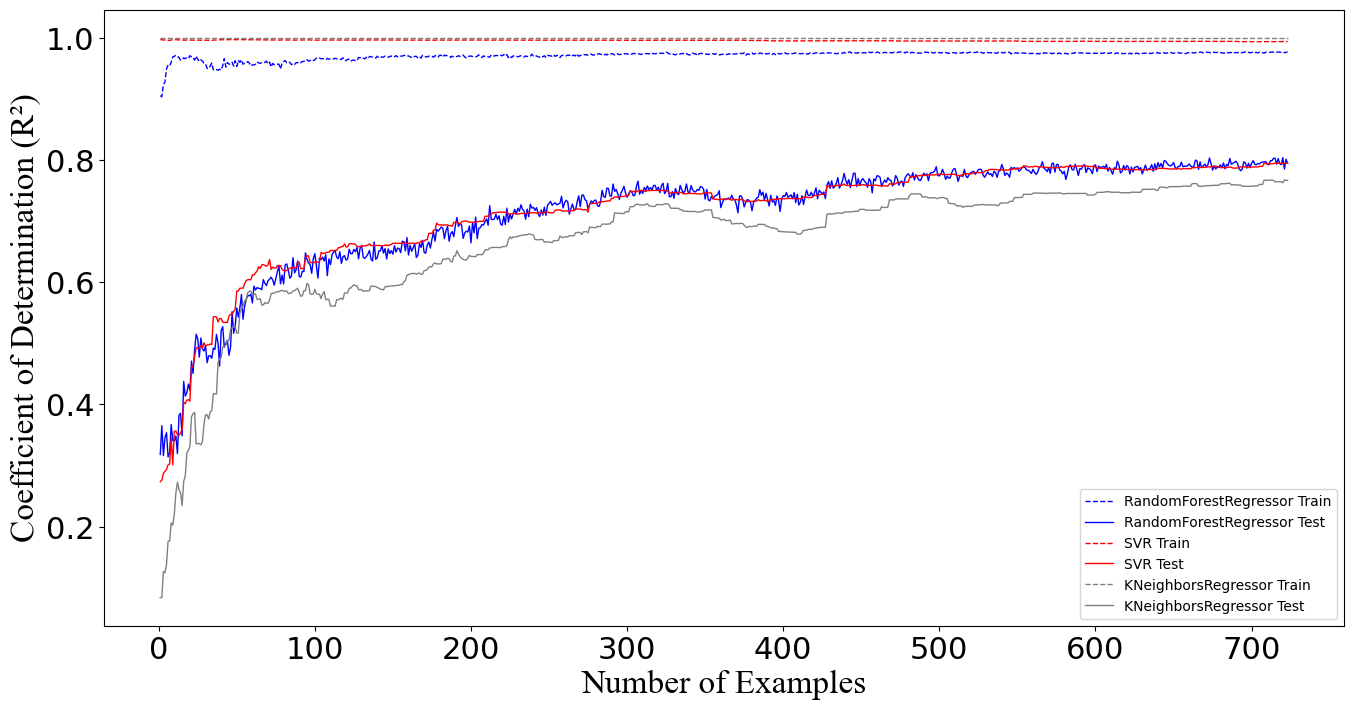

Figure saved successfully.


In [86]:
# Plot learning curves of the top 3 algorithms

np.random.seed(42)
dataset_fp = pd.read_csv('./datasets/x_inhousechembl_fp.csv')
dataset_desc = pd.read_csv('./datasets/x_inhousechembl_desc20.csv')
target = pd.read_csv('./datasets/y_inhousechembl.csv')

estimator1 = rf_inhousechembl #Blue
estimator2 = svr_inhousechembl #Red
estimator3 = knn_inhousechembl #Grey

plot_multi_learning_curves(dataset_fp, dataset_desc, target, estimator1, estimator2, estimator3,
                           random_seed = 42, testsize = 0.2, mode = 'r2', autosave = 'y', interval = None, file_name = 'inhousechembl_desc20')

Current path is: D:\Mitarbeiter\Nava_Hoeer\machine-learning_nozeroldc\figures
Path already existed.


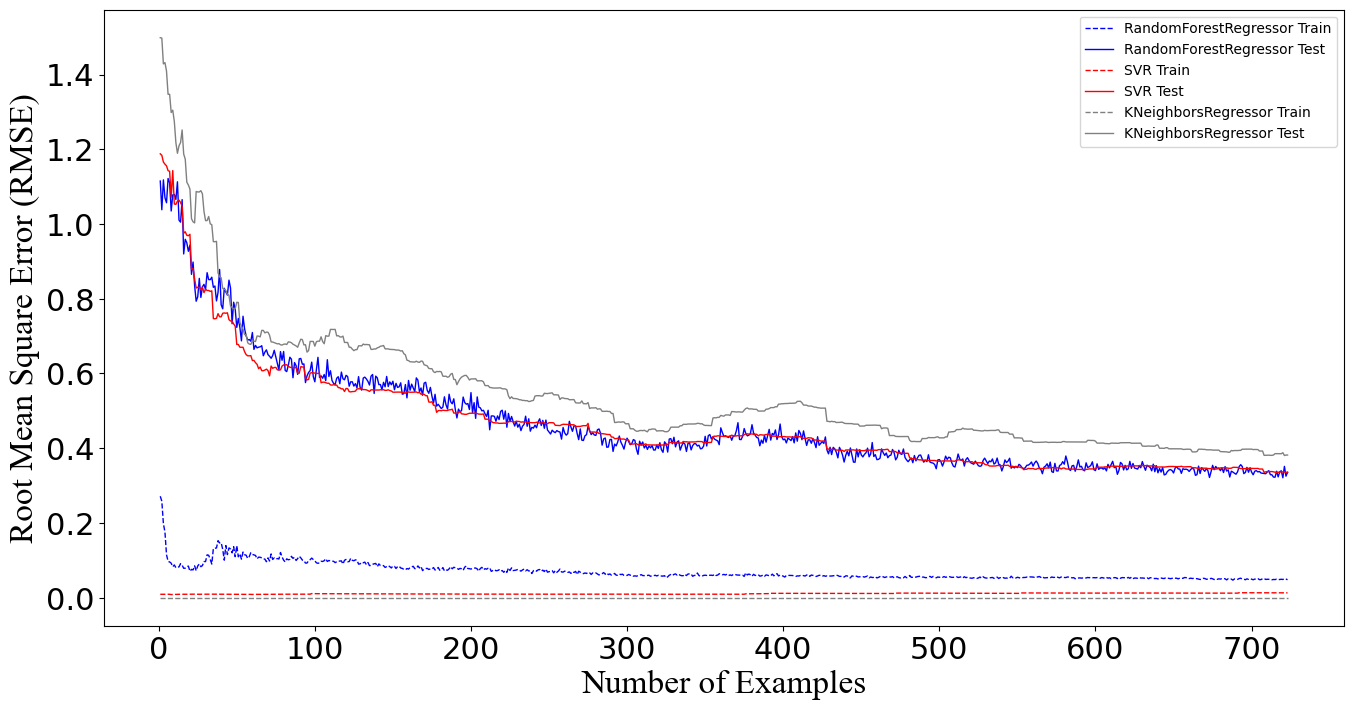

Figure saved successfully.


In [87]:
# Plot learning curves of the top 3 algorithms

np.random.seed(42)
dataset_fp = pd.read_csv('./datasets/x_inhousechembl_fp.csv')
dataset_desc = pd.read_csv('./datasets/x_inhousechembl_desc20.csv')
target = pd.read_csv('./datasets/y_inhousechembl.csv')

estimator1 = rf_inhousechembl #Blue
estimator2 = svr_inhousechembl #Red
estimator3 = knn_inhousechembl #Grey

plot_multi_learning_curves(dataset_fp, dataset_desc, target, estimator1, estimator2, estimator3,
                           random_seed = 42, testsize = 0.2, mode = 'rmse', autosave = 'y', interval = None, file_name = 'inhousechembl_desc20')

# Part C: Model Validation

In [89]:
np.random.seed(42)

# Read Fingerprint, Descriptor and SMILES Datasets
dataset_fp = pd.read_csv('./datasets/x_inhousechembl_fp.csv')
dataset_desc = pd.read_csv('./datasets/x_inhousechembl_desc20.csv')
target = pd.read_csv('./datasets/y_inhousechembl.csv')
df_inhousechembl = pd.read_csv(r'.\datasets\input\inhousechembl.csv', delimiter=',')


x_fp = dataset_fp.values
x_desc = dataset_desc.values
y_data = target.values.ravel()
smiles = df_inhousechembl['smiles'].values

# Join Fingerprint and Descriptor arrays. As The best regressor is random forest scaling is not necessary
x_fp_desc_join = np.concatenate((x_fp, x_desc), axis=1)

# Create 9/1 train/test split
x_train, x_test, y_train, y_test, smiles_train, smiles_test= train_test_split(x_fp_desc_join, y_data, smiles, test_size = 0.1, random_state = 42)

# Find best hyperparameters for training set
regr = RandomForestRegressor()
param_grid = {'bootstrap': [True, False],
             'max_features': [1.0,'log2','sqrt'],
             'min_samples_split': [2,3,4,5,6,7,8,9]}

regr_grid = GridSearchCV(regr, param_grid, scoring = None)
regr_grid.fit(x_train, y_train)

best_estimator = regr_grid.best_estimator_
print('The best hyperparameters:', best_estimator)

# Train model on 90% of In-house+ChEMBL+Desc20
validation_model = best_estimator.fit(x_train, y_train)

# Save validation model
Filename ='./models/' + 'rf_inhousechembl_desc20_90' + '.pkl'
with open (Filename, 'wb') as f:
    pk.dump(validation_model, f)

The best hyperparameters: RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='squared_error',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_samples_leaf=1, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, monotonic_cst=None,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)


In [91]:
# Load validation model
validation_model = joblib.load('./models/rf_inhousechembl_desc20_90.pkl')
# Predict activities on 10% test set using validation model
pred_rf_inhousechembl_desc20_90 = validation_model.predict(x_test)
# Calculate RMSE and R^2 of predictions
test_score_valid = validation_model.score(x_test, y_test)
test_rmse_valid = mean_squared_error(y_test, pred_rf_inhousechembl_desc20_90)
# create dataframe with predictions, labels and smiles
df_pred_valid = pd.DataFrame(np.hstack((smiles_test[:, np.newaxis], pred_rf_inhousechembl_desc20_90[:, np.newaxis], y_test[:, np.newaxis])), columns=['smiles', 'pred_pChEMBL', 'calc_pChEMBL'])
# Save dataframe
df_pred_valid.to_csv('./datasets/inhhousechembl_desc20_90_prediction_results.csv', index=False)

In [92]:
df_pred_valid.head

<bound method NDFrame.head of                                                smiles pred_pChEMBL  \
0   N#Cc1c(cccc1F)N1CCC2(CC(C2)C(=O)NS(=O)(=O)c2cc...     4.316258   
1   CC(NC(=O)C(Cc1ccccc1)NC(=O)C(CCCNC(N)=N)NC(=O)...      6.15146   
2   NC(=O)c1c(NC(=O)COC(=O)CNC(=O)c2ccco2)[s]c2CCCc21     4.052773   
3   NC(=O)c1ccccc1-c1ccc(cc1)C(=O)NS(=O)(=O)c1cc(c...     4.240306   
4   O=C(c1c2ccccc2[n]c2c1CCCC2=Cc1ccco1)N1CCN(CC(=...     4.467579   
..                                                ...          ...   
87          COc1cc2[n]c[n]c(NC(C3CC3)c3ccccc3)c2cc1OC     4.277937   
88  CC(=O)NC(CCCNC(N)=N)C(=O)NC(CCCNC(N)=N)C(=O)NC...     7.236112   
89                  Nc1cc2[nH]c(Cc3ccc(O)cc3)[n]c2cc1     3.085682   
90      NCCNC(=O)c1cc2[nH]c([n]c2cc1)C(=O)c1ccc(O)cc1     3.215636   
91             Cc1cc(C)c(C2=C(O)C3(CCCC3)OC2=O)c(C)c1     3.859818   

   calc_pChEMBL  
0       4.16877  
1      5.920819  
2      4.182798  
3      4.335358  
4      3.759601  
..          ...  
87 

0.7857549731673817

0.2881946888486334

smiles  pred_pChEMBL  \
0   N#Cc1c(cccc1F)N1CCC2(CC(C2)C(=O)NS(=O)(=O)c2cc...      4.316258   
1   CC(NC(=O)C(Cc1ccccc1)NC(=O)C(CCCNC(N)=N)NC(=O)...      6.151460   
2   NC(=O)c1c(NC(=O)COC(=O)CNC(=O)c2ccco2)[s]c2CCCc21      4.052773   
3   NC(=O)c1ccccc1-c1ccc(cc1)C(=O)NS(=O)(=O)c1cc(c...      4.240306   
4   O=C(c1c2ccccc2[n]c2c1CCCC2=Cc1ccco1)N1CCN(CC(=...      4.467579   
5   N#Cc1ccccc1N1CCC2(CC1)CCC(CC2)C=CC(=O)NS(=O)(=...      4.354554   
6   N#CC1C(=O)N=C(NC=1c1ccc[s]1)SCc1cc(ccc1)-c1[nH...      4.431373   
7   N#Cc1ccccc1-c1[nH]c2ccc(cc2[n]1)C(=O)NS(=O)(=O...      4.402229   
8   CC(C)CC(NC(=O)C1COCc2c[n][n][n]2CCCCC(=O)NCC(=...      4.113033   
9   NC(=O)c1ccc(cc1-c1ccc([s]1)C(=O)NS(=O)(=O)c1cc...      4.568864   
10  N#Cc1ccccc1N1CCC2(CC1)CCC(CC(=O)NS(=O)(=O)c1cc...      4.242340   
11  NC(=O)C(C1CCCC1)c1ccc(cc1)C(=O)NS(=O)(=O)c1cc(...      4.419567   
12  CC1Oc2cc(ccc2C(=O)C=1c1ccccc1)OC(C)C(=O)Nc1[s]...      4.904780   
13  Oc1ccc(cc1)C(c1ccc(cc1)OC(=O)Cc1c[nH]c2ccccc21...      3.963088   
14  COc1cccc(c1)-c1cc(ccc1)OCCCC#Cc1ccc(cc1)-c1[nH...      4.980815   
15  CC(=O)NC(CCCNC(N)=N)C(=O)NC(CCCNC(N)=N)C(=O)NC...      8.595586   
16  NC(=O)c1cc(ccc1N1CCC2(CC(C2)C(=O)NS(=O)(=O)c2c...      4.117408   
17  CC(=O)NC(CCCNC(N)=N)C(=O)NC(CCCNC(N)=N)C(=O)NC...      8.888573   
18  O=C1C2CCCCC2C(=NN1C1CCCCCC1)c1cc(ccc1)Oc1[n]cc...      5.170666   
19  NCCNC(=O)c1cc2[n]c([nH]c2cc1)C(=NNc1ccc(F)cc1)...      3.194146   
20                CC(CC(O)=O)(c1ccc(O)cc1)c1ccc(O)cc1      3.140427   
21  CC1NC(=O)C(Cc2ccccc2)NC(=O)C2CCCCNC(=O)c3cc(cc...      5.897706   
22  CC(C)CC(NC(=O)C1CSCc2c[n][n][n]2CCCCC(=O)NC(Cc...      4.067042   
23  CC1(C)C(CCC2(C)C1CCC1(C)C2CCC2C3C(CCC3(CCC12C)...      4.492169   
24  COc1ccc(cc1)-c1[n][n](cc1-c1ccc(cc1)OC)-c1ccc(...      3.854444   
25  CC(C)CC(NC(=O)C1CNC(=O)c2cc3cc(c2)C(=O)NCCCCC(...      5.663962   
26  CC(C)CC(NC(=O)C1COCC=Cc2ccccc2C(=O)NC(C)C(=O)N...      4.106532   
27  N#Cc1cc[n]cc1-c1ccc(cc1)C(=O)NS(=O)(=O)c1cc(cc...      4.338547   
28  CC1(C)C2CCC3(C)C(CCC4C5C(CCC5(CCC34C)C(O)=O)C(...      4.382866   
29  CC1NC(=O)C(Cc2ccccc2)NC(=O)C2CCCCNC(=O)c3cc(cc...      5.741508   
30               COc1c(cc(cc1OC)C=CC(=O)c1cccc[n]1)OC      4.517391   
31    O=C(OCc1c[n]ccc1)c1c2ccccc2[n]c2c1CCC2=Cc1ccco1      4.494882   
32  O=C(Nc1cc(ccc1)-c1[nH][n][n][n]1)C1CN(CCC1)C(=...      4.473381   
33  Fc1cc2c(cccc2cc1)-c1[n]cc2c([n]c([n]c2N2CC3CCC...      6.262078   
34  O=C(NS(=O)(=O)c1cc(cc(c1)C(F)(F)F)C(F)(F)F)C1C...      3.884246   
35  CC1(C)CC2C34OC(=O)C2(CC1)CCC3(C)C1(C)CCC2C(C)(...      4.090769   
36  [2H]C1([2H])CCC2(CC(F)CN12)COc1[n]c(c2c[n]c(-c...      7.380324   
37  CN(C)Cc1ccc(cc1)Nc1ccc(c(F)c1OC)-c1cc(ccc1)OCC...      3.036960   
38     COC(=O)COC(=O)c1c2ccccc2[n]c2c1CCC2=Cc1ccc[s]1      4.336823   
39  CC(=O)NC(CCCNC(N)=N)C(=O)NC(CCCNC(N)=N)C(=O)NC...      7.119599   
40  Cc1ccccc1-c1cc(ccc1)OCCCC#Cc1ccc(cc1)-c1[nH][n...      5.092014   
41  CC(NC(=O)C(Cc1ccccc1)NC(=O)C(CCCNC(N)=N)NC(=O)...      6.131080   
42  C[n]1c(C(O)=O)c(c2cc(Cl)ccc12)-c1ccc(cc1)-c1cc...      4.737745   
43  O=C1C2CCCCC2C(=NN1C1CCCCCC1)c1cc(ccc1)OCCCCCCc...      4.545812   
44  N#Cc1ccccc1N1CC2(C1)CCC(CC2)C(=O)NS(=O)(=O)c1c...      4.306034   
45  CC1CCC2(CCC3(C)C(=CCC4C3(C)CCC3C(C)(CO)C(O)C(O...      3.910510   
46  CC(=O)NC(CCC(O)=O)C(=O)NC1CCC[n]2[n][n]cc2COCC...      4.286287   
47  N#Cc1ccccc1N1CCC2(CC(CCC(=O)NS(=O)(=O)c3cc(cc(...      4.339087   
48        COc1ccc(cc1)-c1[n][n](c(N)c1Br)-c1ccc(F)cc1      3.866739   
49  Cc1cc(-c2cc(c3c[n][n](C(C)C)c3[n]2)C(=O)N2CCN(...      4.064575   
50  N#Cc1ccc(cc1-c1cccc2cc(ccc21)C(=O)NS(=O)(=O)c1...      4.834439   
51  [2H]C([2H])(Oc1[n]c(c2CCN(Cc2[n]1)c1cc(O)ccc1C...      6.699095   
52  NC(=O)c1ccc(Cl)cc1-c1ccc([s]1)C(=O)NS(=O)(=O)c...      4.479387   
53  Oc1cc2ccccc2c(c1)-c1[n]cc2c([n]c([n]c2N2CC3CCC...      7.661737   
54  N#Cc1cc(CCC(=O)NS(=O)(=O)c2cc(cc(c2)C(F)(F)F)C...      4.542731   
55  N#CC(C1CCCC1)c1ccc(cc1)C(=O)NS(=O)(=O)c1cc(cc(...      4.446757   


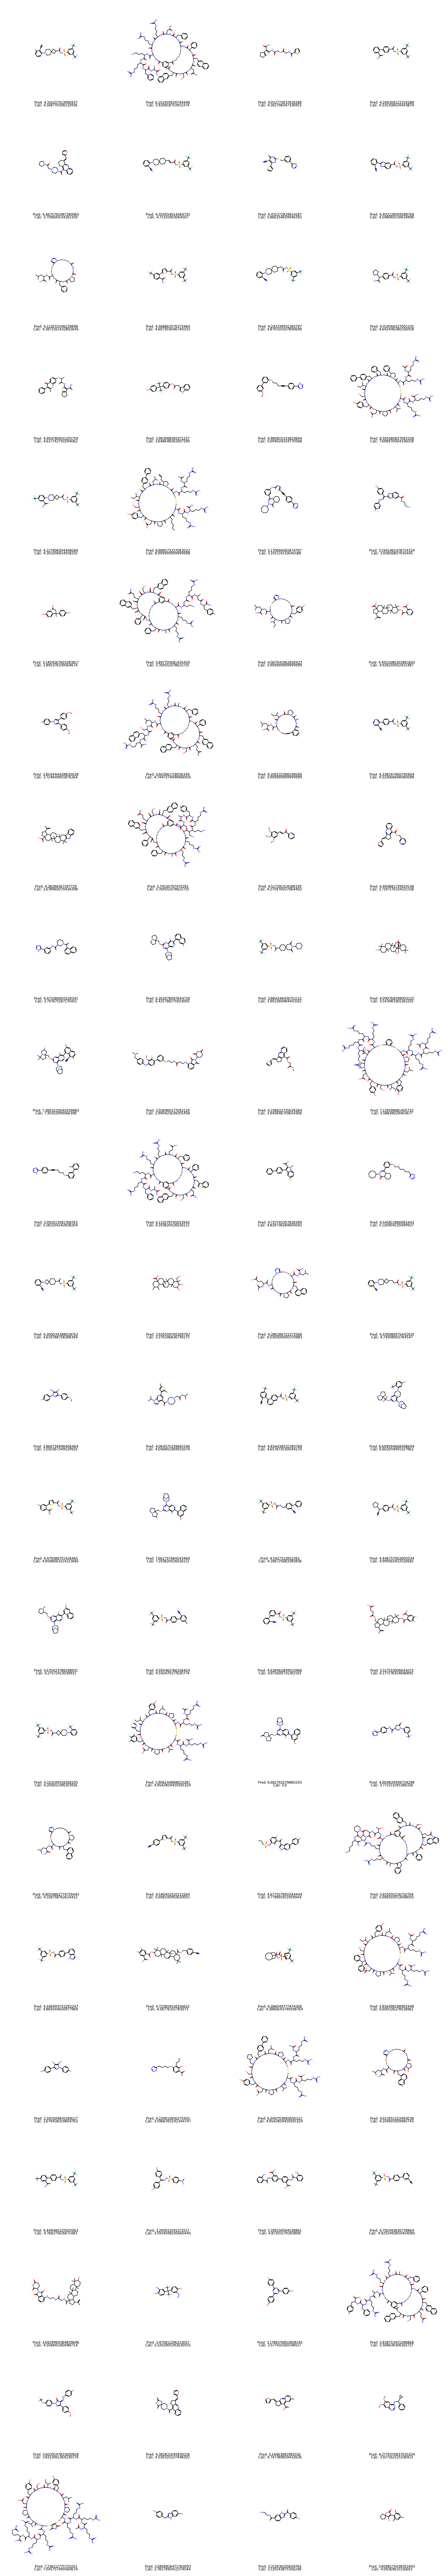

In [93]:
"""Create figure with molecular structures and predicted/measured activites"""

df_pred_valid = pd.read_csv('./datasets/inhhousechembl_desc20_90_prediction_results.csv')

i = 0

Draw_01 = []
row_list = []

for i in range(92):
    row_list.append(i)
    Draw_01.append(Chem.MolFromSmiles(df_pred_valid.iloc[i, 0]))
    i += 1    

pd.set_option('display.max_rows', 139)
display(test_score_valid)
display(test_rmse_valid)
display(df_pred_valid)
img_pred_valid_inhousechembl_desc20_90 = Draw.MolsToGridImage(Draw_01, molsPerRow = 4, subImgSize = (500,500), legends = ['Pred: ' + str(df_pred_valid.iloc[i,1]) + '\n' + '\nCalc: ' + str(df_pred_valid.iloc[i,2]) for i in row_list], returnPNG = False, maxMols=500)    
img_pred_valid_inhousechembl_desc20_90.save('./figures/inhousechembl_desc20_90_prediction_results.png')
Image('./figures/inhousechembl_desc20_90_prediction_results.png')

In [94]:
"""Create final model by training on complete In-house+ChEMBL+Desc Set"""

np.random.seed(42)

# Read Fingerprint and Descriptor datasets
dataset_fp = pd.read_csv('./datasets/x_inhousechembl_fp.csv')
dataset_desc = pd.read_csv('./datasets/x_inhousechembl_desc20.csv')
target = pd.read_csv('./datasets/y_inhousechembl.csv')

x_fp = dataset_fp.values
x_desc = dataset_desc.values
y_data = target.values.ravel()

# Join Fingerprint and Descriptor arrays. As The best regressor is random forest scaling is not necessary
x_fp_desc_join = np.concatenate((x_fp, x_desc), axis=1)

# Find best hyperparameters for training set
regr = RandomForestRegressor()
param_grid = {'bootstrap': [True, False],
             'max_features': [1.0,'log2','sqrt'],
             'min_samples_split': [2,3,4,5,6,7,8,9]}

regr_grid = GridSearchCV(regr, param_grid, scoring = None)
regr_grid.fit(x_fp_desc_join, y_data)

best_estimator = regr_grid.best_estimator_
print('The best hyperparameters:', best_estimator)

# Train model on In-house+ChEMBL+Desc20
final_model = best_estimator.fit(x_fp_desc_join, y_data)

# Save final model
Filename ='./models/' + 'rf_inhousechembl_desc20' + '.pkl'
with open (Filename, 'wb') as f:
    pk.dump(final_model, f)

The best hyperparameters: RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='squared_error',
                      max_depth=None, max_features='log2', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, monotonic_cst=None,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)


# Part D: Prediction of Libraries

In [7]:
# The coconut library raised an error kekulizing one molecule. The number of examples in the descriptor and fingerprint datasets does not match.
# The coconut library was not incuded in this prediction.
database_list = ['bms300k', 'chembl34_dropped', 'clickcyctetpep',  
                 'cyctetpep', 'divset', 'enaminescreening', 
                 'enaminePPI', 'iPPI', 'npatlas', 'reinventPPI', 'chemdivkras']

final_model = joblib.load('./models/rf_inhousechembl_desc20.pkl')

for database in database_list:
    file_name_smiles = '.\\datasets\\input\\'+ database +'.csv'
    file_name_desc = '.\\datasets\\x_'+ database +'_desc20.csv'
    file_name_fp = '.\\datasets\\x_'+ database +'_fp.csv'
    df_smiles = pd.read_csv(file_name_smiles, delimiter=',')
    df_desc = pd.read_csv(file_name_desc, delimiter=',')
    df_fp = pd.read_csv(file_name_fp, delimiter=',')
    df_fp_desc = df_fp.join(df_desc)
    pred = final_model.predict(df_fp_desc.values)
    df_smiles_pred = df_smiles.join(pd.DataFrame(pred))
    df_smiles_pred.columns=['InChI-code', 'smiles', 'pred_pChEMBL']
    df_smiles_pred.to_csv('.\\datasets\\' + database + '_desc20_prediction_results.csv', index = False)

Unnamed: 0                                             smiles  \
17          17  CC(=O)NC(CCCNC(N)=N)C(=O)NC(CCCNC(N)=N)C(=O)NC...   
15          15  CC(=O)NC(CCCNC(N)=N)C(=O)NC(CCCNC(N)=N)C(=O)NC...   
53          53  Oc1cc2ccccc2c(c1)-c1[n]cc2c([n]c([n]c2N2CC3CCC...   
36          36  [2H]C1([2H])CCC2(CC(F)CN12)COc1[n]c(c2c[n]c(-c...   
88          88  CC(=O)NC(CCCNC(N)=N)C(=O)NC(CCCNC(N)=N)C(=O)NC...   
..         ...                                                ...   
72          72         Nc1c(Br)c([n][n]1-c1ccc(F)cc1)-c1ccc(O)cc1   
20          20                CC(CC(O)=O)(c1ccc(O)cc1)c1ccc(O)cc1   
89          89                  Nc1cc2[nH]c(Cc3ccc(O)cc3)[n]c2cc1   
90          90      NCCNC(=O)c1cc2[nH]c([n]c2cc1)C(=O)c1ccc(O)cc1   
37          37  CN(C)Cc1ccc(cc1)Nc1ccc(c(F)c1OC)-c1cc(ccc1)OCC...   

    pred_pChEMBL  calc_pChEMBL  
17      8.803237      9.000000  
15      8.550470      7.698970  
53      7.868769      7.193820  
36      7.306859      7.301030  
88      7.281859      7.045757  
..           ...           ...  
72      3.180174      2.679438  
20      3.143199      2.895376  
89      3.134863      2.781749  
90      3.122718      3.110144  
37      3.071819      2.990422  

[92 rows x 4 columns]

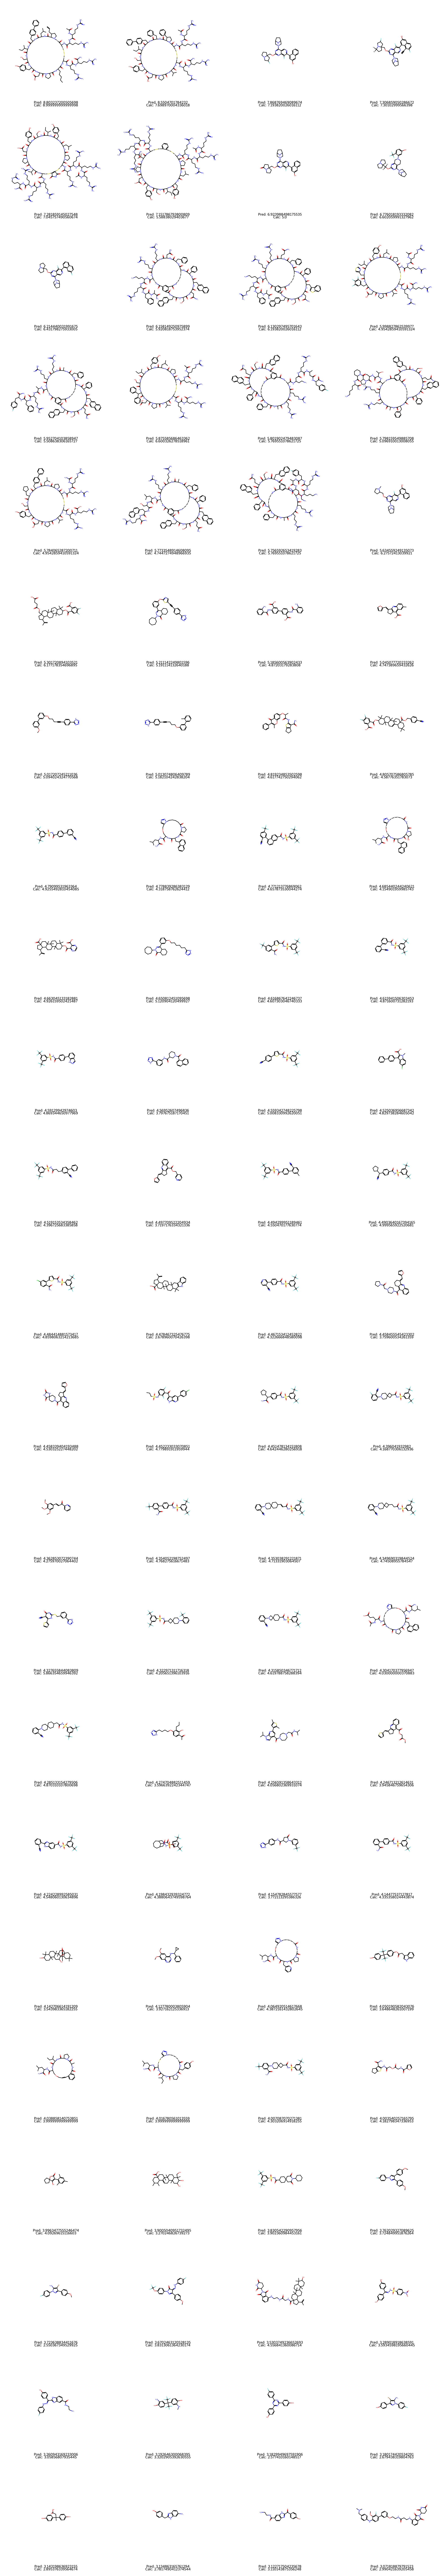

In [14]:
"""Plot validation prediction results again, but sorted descendingly according to predicted pChEMBL."""

file_name_pred = '.\\datasets\\inhousechembl_desc20_90_prediction_results.csv'
df_pred = pd.read_csv(file_name_pred, delimiter=',')
i = 0
df_temp = df_pred.sort_values('pred_pChEMBL', ascending=False)
Draw_temp = []
row_list = []

for i in range(df_temp.shape[0]):
    row_list.append(i)
    Draw_temp.append(Chem.MolFromSmiles(df_temp.iloc[i, 1]))
    i += 1    

pd.set_option('display.max_rows', 10)
display(df_temp)
img_pred_divset = Draw.MolsToGridImage(Draw_temp, molsPerRow = 4, subImgSize = (500,500), legends = ['Pred: ' + str(df_temp.iloc[i,2]) + '\n' + '\nCalc: ' + str(df_temp.iloc[i,3]) for i in row_list], returnPNG = False, maxMols=500)    
img_pred_divset.save('./figures/inhousechembl_desc20_90_prediction_results_top100.png')
Image('./figures/inhousechembl_desc20_90_prediction_results_top100.png')

In [16]:
database_list = ['bms300k', 'chembl34_dropped', 'clickcyctetpep',  
                 'cyctetpep', 'divset', 'enaminescreening', 
                 'enaminePPI', 'iPPI', 'npatlas', 'reinventPPI', 'chemdivkras']

for database in database_list:
    file_name_pred = '.\\datasets\\'+ database +'_desc20_prediction_results.csv'
    df_pred = pd.read_csv(file_name_pred, delimiter=',')
    i = 0
    df_temp = df_pred.sort_values('pred_pChEMBL', ascending=False)
    Draw_temp = []
    row_list = []
    
    for i in range(100):
        row_list.append(i)
        Draw_temp.append(Chem.MolFromSmiles(df_temp.iloc[i, 1]))
        i += 1    
    
    pd.set_option('display.max_rows', 10)
    img_pred_divset = Draw.MolsToGridImage(Draw_temp, molsPerRow = 4, subImgSize = (500,500), legends = ['Pred: ' + str(df_temp.iloc[i,2]) for i in row_list], returnPNG = False, maxMols=500)    
    img_pred_divset.save('./figures/' + database + '_prediction_results_top100.png')

InChI-code  \
94986   InChI=1S/C26H21N5O6/c1-29-20-7-5-4-6-18(20)22-...   
234389  InChI=1S/C21H18ClF3N6/c1-29-7-9-30(10-8-29)19-...   
211638  InChI=1S/C23H15N3O5S2/c27-20-19-14-6-2-4-8-17(...   
201439  InChI=1S/C22H20N2O4S2/c1-14-5-9-17(13-20(14)24...   
281159  InChI=1S/C22H14F2N8O2S/c23-20(24)14-10-13(12-4...   
...                                                   ...   
38295   InChI=1S/C9H8N2OS/c10-9-11-8(5-13-9)6-1-3-7(12...   
34066   InChI=1S/C10H9NO/c12-10-5-3-9(4-6-10)11-7-1-2-...   
61732   InChI=1S/C13H10N2S/c14-10-7-5-9(6-8-10)13-15-1...   
24704   InChI=1S/C9H6N2S2/c10-5-6-12-9-11-7-3-1-2-4-8(...   
159755  InChI=1S/C13H10N2S2/c14-9-5-1-3-7-11(9)16-13-1...   

                                                   smiles  pred_pChEMBL  
94986   COc1ccc(N2N=C(C(=O)Nc3cc(N(=O)=O)ccc3OC)c3c([n...      5.086921  
234389  CN1CCN(c2[n]c3c(-c4cc(C(F)(F)F)ccc4)[n][n][n]3...      5.023964  
211638  O=C1N=C2SC(=Cc3ccc(-c4ccccc4N(=O)=O)o3)C(=O)N2...      4.999173  
201439  Cc1ccc(S(=O)(=O)N2CCSC2c2ccc3CCc4c3c2ccc4)cc1N...      4.974863  
281159  O=N(=O)c1[n][n](CCc2[n][n]3c[n]c4c(c3[n]2)[s]c...      4.972628  
...                                                   ...           ...  
38295                          Nc1[n]c(-c2ccc(O)cc2)c[s]1      2.903451  
34066                               Oc1ccc(-[n]2cccc2)cc1      2.871342  
61732                       Nc1ccc(-c2[n]c3ccccc3[s]2)cc1      2.866095  
24704                              N#CCSc1[n]c2ccccc2[s]1      2.859070  
159755                        Nc1ccccc1Sc1[n]c2ccccc2[s]1      2.715315  

[299919 rows x 3 columns]

InChI-code  \
724541   InChI=1S/C31H31ClF2N6O2/c32-24-4-1-3-17-9-21(4...   
752522   InChI=1S/C33H32F2N6O2/c1-2-19-5-3-6-20-11-24(4...   
748067   InChI=1S/C31H30F4N6O2/c32-17-10-31(6-1-7-41(31...   
753220   InChI=1S/C32H38FIN6O2/c33-21-6-10-38(14-21)18-...   
741179   InChI=1S/C33H35F3N6O2/c1-2-23-26(35)7-4-18-10-...   
...                                                    ...   
1147780  InChI=1S/C6H6O4S/c7-5-1-3-6(4-2-5)11(8,9)10/h1...   
908213   InChI=1S/C8H7NS2/c1-10-8-9-6-4-2-3-5-7(6)11-8/...   
1211522  InChI=1S/C13H10N2S2/c14-9-5-7-10(8-6-9)16-13-1...   
472079   InChI=1S/C36H49NO2/c1-21(2)22-14-17-36(31(38)3...   
125510   InChI=1S/C12H11NO3S/c13-9-1-5-11(6-2-9)17(15,1...   

                                                    smiles  pred_pChEMBL  
724541   Oc1cc(-c2c(F)c3[n]c(OCC45CCCN4CC(F)C5)[n]c(N4C...      9.576131  
752522   C#Cc1cccc2cc(O)cc(-c3c(F)c4[n]c(OCC56CCCN5CC(F...      9.327569  
748067   Oc1cc(-c2c(F)c3[n]c(OCC45CCCN4CC(F)C5)[n]c(N4C...      9.192880  
753220   Oc1cc2c(c(I)ccc2)c(N2CCc3c(N4CC5CCC(N5)C4)[n]c...      9.038013  
741179   CCc1c(F)ccc2cc(O)cc(-c3c(F)c4[n]c(OCC56CCCN5CC...      9.002452  
...                                                    ...           ...  
1147780                              O=S(=O)(O)c1ccc(O)cc1      2.792402  
908213                               CSc1[n]c2c(cccc2)[s]1      2.785689  
1211522                      Nc1ccc(Sc2[n]c3ccccc3[s]2)cc1      2.777587  
472079   C=C(C)C1CCC2(C(=O)O)CCC3(C)C(C12)CCC1C2(C)Cc4c...      2.763163  
125510                     Nc1ccc(S(=O)(=O)c2ccc(O)cc2)cc1      2.659111  

[2188592 rows x 3 columns]

InChI-code  \
151774  InChI=1S/C38H36N10O3/c49-36-32(15-24-18-40-29-...   
151775  InChI=1S/C38H36N10O3/c49-36-32(15-24-18-40-29-...   
151776  InChI=1S/C38H36N10O3/c49-36-32(15-24-18-40-29-...   
149673  InChI=1S/C33H38N10O3/c34-13-7-6-12-26-31(44)39...   
151181  InChI=1S/C35H38N10O3/c1-3-20(2)32-35(48)41-29(...   
...                                                   ...   
29324   InChI=1S/C19H24N6O4/c1-10-15-9-25(24-23-15)16(...   
5467    InChI=1S/C16H18N6O4/c23-11-3-1-10(2-4-11)5-12-...   
11535   InChI=1S/C17H24N6O4/c1-10(24)15-16(26)18-8-14(...   
10593   InChI=1S/C17H20N6O4/c1-10-13-9-23(22-21-13)14(...   
5470    InChI=1S/C16H18N6O4/c23-12-3-1-10(2-4-12)5-13-...   

                                                   smiles  pred_pChEMBL  
151774  O=C1NC(Cc2c[nH]c3ccccc23)C(=O)NC(Cc2ccccc2)c2c...      4.928761  
151775  O=C1NC(Cc2c[nH]c3ccccc23)C(=O)NC(Cc2ccccc2)c2c...      4.923030  
151776  O=C1NC(Cc2c[nH]c[n]2)C(=O)NC(Cc2ccccc2)c2c[n](...      4.923030  
149673  NCCCCC1NC(=O)C(Cc2c[nH]c3ccccc23)NC(=O)C(Cc2c[...      4.915882  
151181  CC(CC)C1NC(=O)C(Cc2c[nH]c3ccccc23)[n]2cc([n][n...      4.900895  
...                                                   ...           ...  
29324   CC1NC(=O)C(C)NC(=O)C(C)NC(=O)C(Cc2ccc(O)cc2)[n...      3.638702  
5467    Oc1ccc(CC2NC(=O)CNC(=O)CNC(=O)C[n]3cc2[n][n]3)cc1      3.635844  
11535   CC(O)C1C(=O)NCC(=O)N2CCCC2C(=O)N2CCCC2c2c[n]1[...      3.621360  
10593   CC1NC(=O)CNC(=O)CNC(=O)C(Cc2ccc(O)cc2)[n]2cc1[...      3.615089  
5470    Oc1ccc(CC2C(=O)NCC(=O)NCC(=O)NCc3c[n]2[n][n]3)cc1      3.593536  

[152000 rows x 3 columns]

InChI-code  \
40103  InChI=1S/C42H39N7O4/c50-39-35(18-25-10-2-1-3-1...   
39540  InChI=1S/C32H38N8O4/c33-13-7-6-12-25-29(41)40-...   
39539  InChI=1S/C32H38N8O4/c33-13-7-6-12-25-29(41)40-...   
39537  InChI=1S/C32H38N8O4/c33-13-7-6-12-25-29(41)39-...   
39536  InChI=1S/C32H38N8O4/c33-13-7-6-12-25-29(41)38-...   
...                                                  ...   
40107  InChI=1S/C9H14N4O4/c1-5-9(17)12-3-7(15)10-2-6(...   
5286   InChI=1S/C17H26N4O4/c1-10(2)14-16(24)18-9-13(2...   
40109  InChI=1S/C9H14N4O5/c14-4-5-9(18)12-2-7(16)10-1...   
12128  InChI=1S/C19H30N4O5/c1-10(2)14-19(28)23-9-5-7-...   
40106  InChI=1S/C8H12N4O4/c13-5-1-9-6(14)2-11-8(16)4-...   

                                                  smiles  pred_pChEMBL  
40103  O=C1NC(Cc2c[nH]c3ccccc23)C(=O)NC(Cc2c[nH]c3ccc...      4.857055  
39540  NCCCCC1NC(=O)C(Cc2ccccc2)NC(=O)C(Cc2c[nH]c3ccc...      4.811464  
39539  NCCCCC1NC(=O)C(Cc2c[nH]c3ccccc23)NC(=O)C(Cc2cc...      4.811464  
39537  NCCCCC1NC(=O)C(Cc2c[nH]c[n]2)NC(=O)C(Cc2ccccc2...      4.811464  
39536  NCCCCC1NC(=O)C(Cc2c[nH]c3ccccc23)NC(=O)C(Cc2c[...      4.811464  
...                                                  ...           ...  
40107                      CC1NC(=O)CNC(=O)CNC(=O)CNC1=O      3.622549  
5286         CC(C)C1NC(=O)C2CCCN2C(=O)C2CCCN2C(=O)CNC1=O      3.611969  
40109                     OCC1NC(=O)CNC(=O)CNC(=O)CNC1=O      3.605826  
12128  CC(C)C1NC(=O)C(NC(=O)C2CCCN2C(=O)C2CCCN2C1=O)C...      3.600970  
40106                       O=C1CNC(=O)CNC(=O)CNC(=O)CN1      3.524253  

[40110 rows x 3 columns]

InChI-code  \
9720   InChI=1S/C28H26N6O3/c1-18-20-7-3-4-8-21(20)28(...   
15069  InChI=1S/C24H23ClN4O4/c1-14-23-16(15-8-6-5-7-9...   
8796   InChI=1S/C21H20N4O3/c1-15(11-20(26)23-18-7-4-1...   
11978  InChI=1S/C27H31N5O3/c1-3-32-24-9-5-4-8-23(24)3...   
15408  InChI=1S/C25H25FN6O3/c1-15-11-16(2)31(28-15)10...   
...                                                  ...   
34435  InChI=1S/C10H8N2O3/c13-8-3-1-7(2-4-8)12-6-5-11...   
44591  InChI=1S/C12H13N3O/c1-8-7-9(2)14-12(13-8)15-10...   
32277  InChI=1S/C8H7N3O/c9-7-8(12)11-6-4-2-1-3-5(6)10...   
26946  InChI=1S/C12H12N2S/c13-9-1-5-11(6-2-9)15-12-7-...   
32039  InChI=1S/C10H10N2O2/c11-5-8-6-14-12-10(8)7-1-3...   

                                                  smiles  pred_pChEMBL  
9720   CC1=NN(CC(=O)Nc2ccc(cc2OC)N2CC[n]3c(C2)[n]c2cc...      5.154706  
15069  Cc1[n][n](C)c2[n]c(cc(c12)-c1ccccc1)OCC(=O)Nc1...      4.950005  
8796       CC(CC(=O)Nc1c[n]ccc1)=NNC(=O)COc1cc2ccccc2cc1      4.892993  
11978  CCN1c2ccccc2N=C(C1=O)N1CCCC(C1)C(=O)NCCc1c[nH]...      4.892388  
15408  Cc1cc(C)[n][n]1CCc1[n]c2-c3cc(OC)c(cc3N(Cc3ccc...      4.874315  
...                                                  ...           ...  
34435                         Oc1ccc(cc1)N1C=CNC(=O)C1=O      2.989129  
44591                     Cc1cc(C)[n]c(Nc2ccc(O)cc2)[n]1      2.983416  
32277                               Nc1[n]c2ccccc2[n]c1O      2.983268  
26946                            Nc1ccc(cc1)Sc1ccc(N)cc1      2.979832  
32039                            NCc1co[n]c1-c1ccc(O)cc1      2.860250  

[49854 rows x 3 columns]

InChI-code  \
4308556  InChI=1S/C66H103N17O16S/c1-9-35(6)52(69)66-81-...   
4308279  InChI=1S/C43H58N4O12/c1-21-12-11-13-22(2)42(55...   
3634976  InChI=1S/C99H140N20O17/c1-51(2)37-73(109-86(12...   
4308288  InChI=1S/C66H75Cl2N9O24/c1-23(2)12-34(71-5)58(...   
1543459  InChI=1S/C49H38ClN3P2/c50-48-37-39(31-36-49(48...   
...                                                    ...   
4296506  InChI=1S/C6H5FO3S/c7-11(9,10)6-3-1-5(8)2-4-6/h...   
1567868  InChI=1S/C12H9ClO3S/c13-9-1-5-11(6-2-9)17(15,1...   
71556    InChI=1S/C14H14O/c1-11(12-5-3-2-4-6-12)13-7-9-...   
2361958  InChI=1S/C24H28N4O3/c1-16(2)21-20-13-19(15-26-...   
87574    InChI=1S/C12H10O3S/c13-10-6-8-12(9-7-10)16(14,...   

                                                    smiles  pred_pChEMBL  
4308556  CCC(C)C(N)C1=NC(C(=O)NC(CC(C)C)C(=O)NC(CCC(=O)...      5.747678  
4308279  COC1C=COC2(C)Oc3c(C2=O)c2c(O)c(C=NN4CCN(C)CC4)...      5.552408  
3634976  CC(C)CC(NC(=O)C(C)NC(=O)CNC(=O)C(NC=O)C(C)C)C(...      5.465616  
4308288  CNC(CC(C)C)C(=O)NC1C(=O)NC(CC(N)=O)C(=O)NC2C(=...      5.463017  
1543459  Clc1cc(C=Nc2ccc(N=P(c3ccccc3)(c3ccccc3)c3ccccc...      5.461982  
...                                                    ...           ...  
4296506                              O=S(=O)(F)c1ccc(O)cc1      2.777115  
1567868                   O=S(=O)(c1ccc(O)cc1)c1ccc(Cl)cc1      2.720191  
71556                              CC(c1ccccc1)c1ccc(O)cc1      2.719869  
2361958  CC(C)c1[n]oc2[n]cc(C(=O)NCc3ccc(C(=O)N4CCCCCC4...      2.711806  
87574                         O=S(=O)(c1ccccc1)c1ccc(O)cc1      2.640655  

[4315298 rows x 3 columns]

InChI-code  \
33756  InChI=1S/C22H20N2O3S/c25-21-9-12-28-20-8-6-17(...   
38882  InChI=1S/C25H22N4O4/c1-15-8-9-28-21(10-15)26-1...   
18648  InChI=1S/C18H22N6O2S/c1-12-5-6-15-14(8-12)18(2...   
15418  InChI=1S/C18H15N7O/c26-18(24-16-5-1-3-13-9-19-...   
9942   InChI=1S/C17H13F3N6/c18-17(19,20)16-23-22-14-5...   
...                                                  ...   
27709  InChI=1S/C20H21N3O3/c24-16-9-7-14(8-10-16)12-2...   
47     InChI=1S/C11H10N2O2S/c12-11-13-10(7-4-2-1-3-5-...   
5387   InChI=1S/C15H22N2O2/c16-15(19)11-17-9-7-13(8-1...   
7978   InChI=1S/C16H19N3O2/c1-19-10-12(9-18-19)14-8-1...   
3465   InChI=1S/C15H14N4O/c20-12-6-4-11(5-7-12)9-17-1...   

                                                  smiles  pred_pChEMBL  
33756         O=C1CCSc2ccc(cc2N1)C(=O)NCCOc1cc2ccccc2cc1      5.057553  
38882  CC1C=CN2C(C=1)=NC(CN1C(=O)NC(C)(C1=O)c1cc3ccc(...      4.941318  
18648  Cc1cc2c(cc1)[n]c[n]c2N1CC(CCC1)c1[n][nH]cc1NS(...      4.883141  
15418   O=C(NCc1ccc[n]c1-[n]1c[n]c[n]1)Nc1cccc2c[n]ccc21      4.845938  
9942   FC(F)(F)c1[n][n]c2ccc([n][n]21)N1Cc2c3ccccc3[n...      4.827362  
...                                                  ...           ...  
27709        Oc1ccc(CNC(=O)N2CC(CCC2)c2[n]c3ccccc3o2)cc1      3.258778  
47                      Nc1[n]c(c(CC(O)=O)[s]1)-c1ccccc1      3.258581  
5387                      NC(=O)CN1CCC(CCc2ccc(O)cc2)CC1      3.246650  
7978              C[n]1cc(c[n]1)C1CC1C(=O)NCCc1ccc(O)cc1      3.229635  
3465                Oc1ccc(CNc2c[nH][n]c2-c2cccc[n]2)cc1      3.159024  

[40255 rows x 3 columns]

InChI-code  \
2270  InChI=1S/C45H53ClN6O4S3/c1-5-35(30-57-37-12-7-...   
2259  InChI=1S/C45H50ClF3N6O5S3/c1-54(2)24-20-34(29-...   
2280  InChI=1S/C46H52ClF3N6O5S3/c1-55(2)25-21-35(30-...   
2236  InChI=1S/C44H48ClF4N7O4S3/c1-54(2)21-18-33(28-...   
2278  InChI=1S/C46H50ClF4N7O5S3/c47-34-12-10-32(11-1...   
...                                                 ...   
2336  InChI=1S/C9H11N3/c1-2-12-8-6-4-3-5-7(8)11-9(12...   
42    InChI=1S/C12H6Cl4/c13-7-3-1-4-8(14)11(7)12-9(1...   
43    InChI=1S/C12H6Cl4/c13-9-1-7(2-10(14)5-9)8-3-11...   
47    InChI=1S/C12H7Cl3O/c13-8-5-10(14)12(11(15)6-8)...   
2317  InChI=1S/C7H6N2S/c8-7-9-5-3-1-2-4-6(5)10-7/h1-...   

                                                 smiles  pred_pChEMBL  
2270  CCC(CSc1ccccc1)Nc1ccc(cc1S(=O)(=O)C(C)(C)C)S(=...      5.192362  
2259  CN(C)CCC(CSc1ccccc1)Nc1ccc(cc1S(=O)(=O)C(F)(F)...      5.140729  
2280  CN(C)CCC(CSc1ccccc1)Nc1ccc(cc1S(=O)(=O)C(F)(F)...      5.097529  
2236  CN(C)CCC(CSc1ccccc1)Nc1ccc(cc1S(=O)(=O)C(F)(F)...      5.084670  
2278  O=S(=O)(c1cc(ccc1NC(CCN1CCOCC1)CSc1ccccc1)S(=O...      5.072995  
...                                                 ...           ...  
2336                             CC[n]1c(N)[n]c2ccccc12      3.186290  
42                        Clc1cccc(Cl)c1-c1c(Cl)cccc1Cl      3.128023  
43                    Clc1cc(Cl)cc(c1)-c1cc(Cl)cc(Cl)c1      3.066845  
47                       Oc1ccc(cc1)-c1c(Cl)cc(Cl)cc1Cl      3.038029  
2317                                 Nc1[n]c2ccccc2[s]1      2.886198  

[2345 rows x 3 columns]

InChI-code  \
8163   InChI=1S/C113H142N26O27/c1-6-61(4)95(108(161)1...   
26311  InChI=1S/C75H97BrN16O26/c1-35(17-18-38-11-6-4-...   
30588  InChI=1S/C69H87BrN16O22/c1-34(13-14-36-15-17-3...   
26309  InChI=1S/C69H87BrN16O22/c1-34(13-14-36-9-5-3-6...   
3800   InChI=1S/C105H130N24O24/c1-6-57(4)89(104(152)1...   
...                                                  ...   
29787  InChI=1S/C8H8O3/c9-7-3-1-6(2-4-7)5-8(10)11/h1-...   
5702   InChI=1S/C6H6N2O4S/c9-6-3-1-5(2-4-6)7-8-13(10,...   
3124   InChI=1S/C13H17NO3/c1-9(2)7-13(17)14-8-12(16)1...   
25687  InChI=1S/C8H10O3/c9-5-8(11)6-1-3-7(10)4-2-6/h1...   
2072     InChI=1S/C6H4N2O/c7-8-5-1-3-6(9)4-2-5/h1-4H/p+1   

                                                  smiles  pred_pChEMBL  
8163   CC(C)CC(NC(=O)C1CC(=O)NCC(=O)NC(Cc2ccc(O)cc2)C...      6.328267  
26311  CC(C=Cc1ccccc1)=CC(O)C1CC(=O)NC(CO)C(=O)NC2C[n...      6.315601  
30588  CC(C=Cc1ccc(Br)cc1)=CC(O)C1CC(=O)NC(CO)C(=O)NC...      6.294331  
26309  CC(C=Cc1ccccc1)=CC(O)C1CC(=O)NC(CO)C(=O)NC2C[n...      6.246983  
3800   CC(C)CC(NC(=O)C1CC(=O)NCC(=O)NC(Cc2ccc(O)cc2)C...      6.236353  
...                                                  ...           ...  
29787                                 Oc1ccc(CC(O)=O)cc1      2.968388  
5702                            Oc1ccc(cc1)N=NS(O)(=O)=O      2.963899  
3124                       CC(C)CC(=O)NCC(=O)c1ccc(O)cc1      2.958736  
25687                                  Oc1ccc(cc1)C(O)CO      2.907389  
2072                                   N#[N+]c1ccc(O)cc1      2.893619  

[33319 rows x 3 columns]

InChI-code  \
11225  InChI=1S/C36H43FN6O3/c1-5-41-14-16-42(17-15-41...   
6886   InChI=1S/C25H25FN6O/c26-23-14-31-25(22(15-33)2...   
11148  InChI=1S/C34H28Cl3FN4O4S/c1-18-24-13-19-4-2-3-...   
9965   InChI=1S/C29H21F4N3O3/c1-16(37)35-26-11-10-17(...   
10954  InChI=1S/C31H42N6O/c1-22-20-26(8-9-28(22)31(38...   
...                                                  ...   
3671   InChI=1S/C22H23N3OS/c1-15-5-6-19(12-16(15)2)21...   
28     InChI=1S/C14H11Cl2N3S/c15-10-5-11(16)7-12(6-10...   
7      InChI=1S/C12H14ClN3S/c1-2-3-8-16-11(14-15-12(1...   
10     InChI=1S/C12H9ClFNO2S/c13-8-2-1-7(10(14)3-8)6-...   
19     InChI=1S/C13H15Cl2N3/c1-8(9-4-10(14)6-11(15)5-...   

                                                  smiles  pred_pChEMBL  
11225  Cc1c[n]c(cc1-c1cc(c(cc1)C(=O)N1C(C)CCC1C)C(=O)...      5.121081  
6886   OCc1c([n]cc(F)c1-c1c[n]c[n]c1)N1CCC(CC1)NCc1cc...      5.023482  
11148  CC1C2=Cc3ccccc3S(=O)(NC(=O)C3CCN3C3OC(CC3NC(=O...      4.987509  
9965   CC(=O)Nc1ccc(cc1C(=O)Nc1ccccc1)-c1cc(F)c(c(F)c...      4.911351  
10954  Cc1cc[n](CCNC(=O)c2ccc(cc2C)-c2cc([n]c(C)c2C)N...      4.889172  
...                                                  ...           ...  
3671        Cc1cc(ccc1C)C(NC(=S)NCc1c[n]ccc1)c1ccc(O)cc1      3.501648  
28                 Clc1cc(cc(Cl)c1)Sc1ccc(c[n]1)C1NCCN=1      3.501610  
7                             CCCCN1C(=S)NN=C1c1ccccc1Cl      3.486542  
10                        OC1=CC(=CNC1=O)SCc1ccc(Cl)cc1F      3.412179  
19                 CC(c1[nH]cc(CCN)[n]1)c1cc(Cl)cc(Cl)c1      3.381224  

[11241 rows x 3 columns]